In [1]:
#imports
import pandas as pd
import numpy as np
import nltk, sklearn, scipy
import os
import visualization, word2vec, preprocessing #local files with visualization functions
from IPython import display

In [2]:
#config
pd.options.mode.chained_assignment = None 

In [3]:
#parameters
PERMITTED_PoS = ['JJ', 'NN', 'NNS', 'NNP', 'VBP']
INPUT_FILE = '../extreme right antisemitism _ new.csv'
CLEAN_NAME = 'clean.csv'
INPUT_COLUMN = 'Post'
DATE_COLUMN = 'Date'
COMPARE_WORDS = ['zog', 'kike', 'george_soros', 'rothschild']
MAX_LENGTH = 11 #max length for a word

lemmatizer = nltk.stem.WordNetLemmatizer()
#if os.path.exists(CLEAN_NAME):
#    df = pd.read_csv(CLEAN_NAME)
#else:
df = pd.read_csv(INPUT_FILE)
df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN])
start_date = pd.to_datetime('2022-12-24')
df = preprocessing.fully_clean(df, start_date, INPUT_COLUMN, lemmatizer, PERMITTED_PoS, MAX_LENGTH)
#df.to_csv(CLEAN_NAME, index=False)

inputs = df[INPUT_COLUMN].tolist()

In [4]:
def is_antisemitic(x: pd.Series, df: pd.DataFrame, num: int) -> bool:
    '''Determine if an example is antisemitic: if it is in the top 20% closest in general or top 10% on one column.'''
    return x[num] > np.percentile(df.iloc[:, num], 80) or any([x[i] > np.percentile(df.iloc[:, i], 90) for i in range(num)])

def find_ngrams(n: int, inputs: list[str]) -> pd.DataFrame:
    '''Find the n-gram dataframe for a given n.'''
    vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(ngram_range=(n, n))
    bigrams = visualization.find_and_visualize(inputs, lemmatizer, 
                                                 PERMITTED_PoS, MAX_LENGTH, n, vectorizer)
    print('\n')
    
    #word2vec calculations
    similarity_df = word2vec.get_similarities(df, start_date, INPUT_COLUMN, DATE_COLUMN, bigrams, 
                    COMPARE_WORDS, lemmatizer, PERMITTED_PoS, MAX_LENGTH, n)
    
    #determination of antisemitism
    similarity_df['Classification'] = similarity_df.apply(lambda x: is_antisemitic(x, similarity_df, len(COMPARE_WORDS)), axis=1)
    similarity_df.to_csv(f'output-{n}.csv')
    return similarity_df.sort_values(['Classification', 'Mean'], ascending=False)

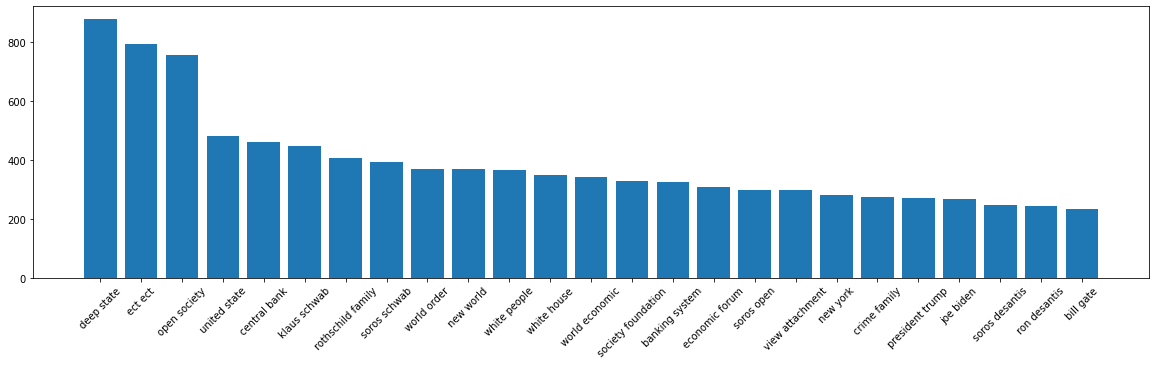

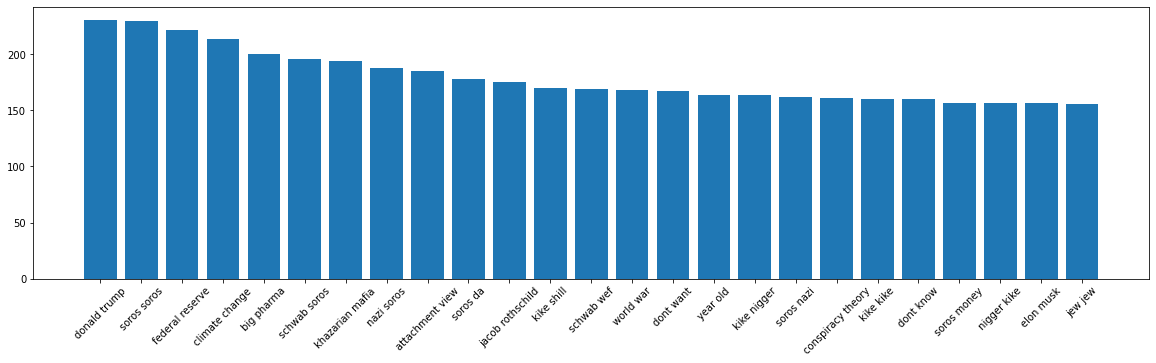

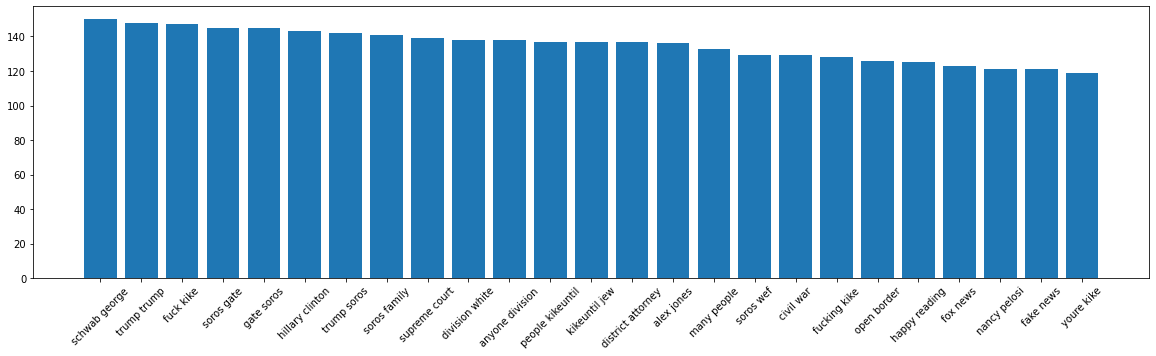

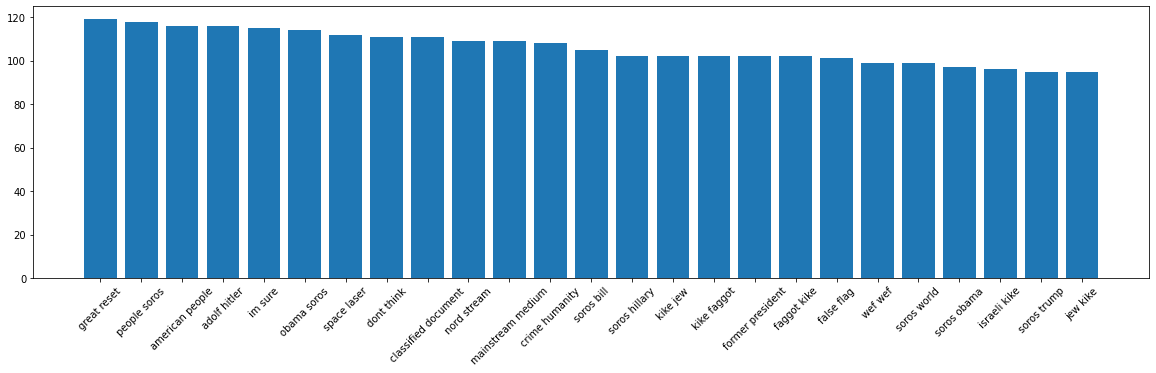

,zog,kike,george_soros,rothschild,Mean,Classification
kike_jew,0.479292,0.717646,0.260210,0.258036,0.428796,True
fucking_kike,0.471952,0.709109,0.261462,0.269870,0.428098,True
kike_faggot,0.459504,0.656659,0.282840,0.236048,0.408763,True
kike_kike,0.520296,0.691344,0.213225,0.205439,0.407576,True
soros_wef,0.434450,0.406570,0.477164,0.305776,0.405990,True
society_foundation,0.397516,0.494547,0.371079,0.342028,0.401292,True
schwab_george,0.373120,0.489146,0.379137,0.351824,0.398307,True
nigger_kike,0.518325,0.668605,0.234602,0.170456,0.397997,True
im_sure,0.393209,0.546665,0.339669,0.277716,0.389315,True
youre_kike,0.471457,0.673557,0.207625,0.203469,0.389027,True


In [5]:
#bigrams
display.HTML(find_ngrams(2, inputs).to_html())

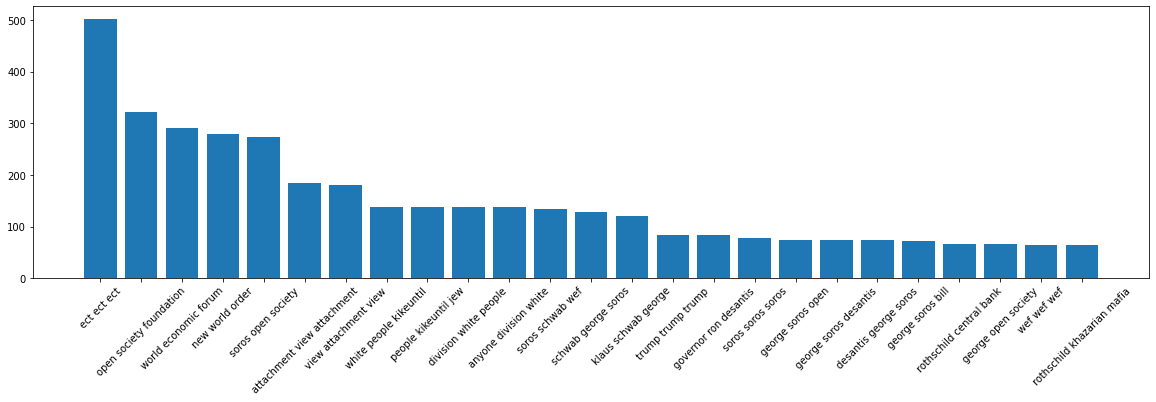

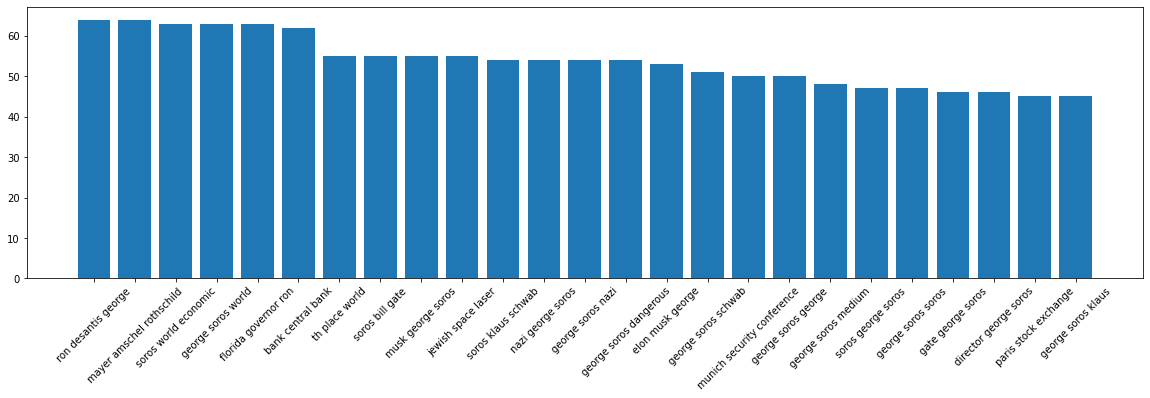

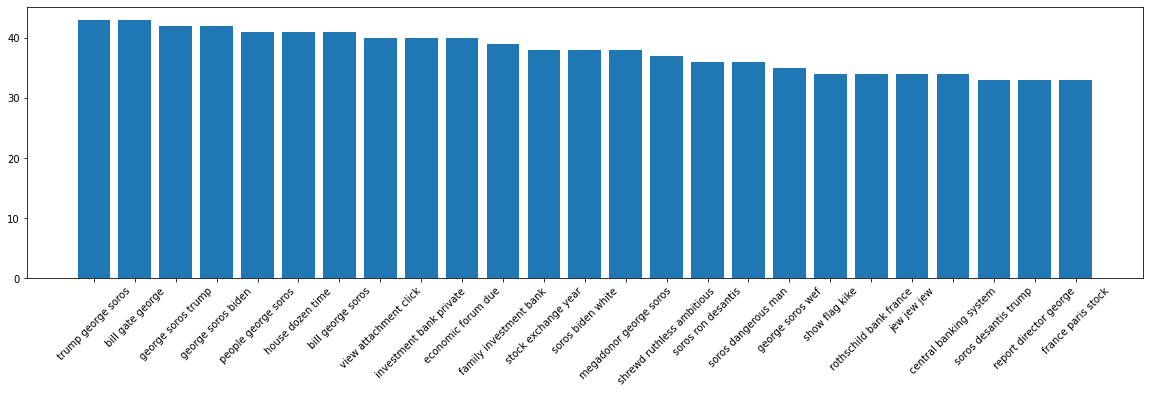

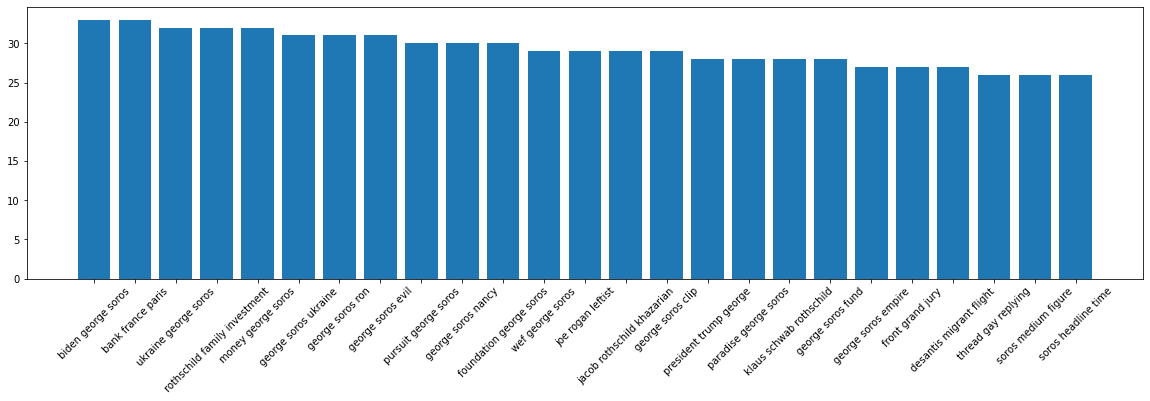

,zog,kike,george_soros,rothschild,Mean,Classification
show_flag_kike,0.423535,0.565925,0.344278,0.283497,0.404309,True
president_trump_george,0.409387,0.462934,0.390429,0.318472,0.395306,True
soros_dangerous_man,0.371219,0.440651,0.447013,0.266732,0.381404,True
soros_bill_gate,0.386333,0.404976,0.395364,0.331842,0.379629,True
jew_jew_jew,0.467710,0.552926,0.262730,0.222577,0.376486,True
elon_musk_george,0.362607,0.470092,0.362761,0.305456,0.375229,True
jacob_rothschild_khazarian,0.371083,0.429600,0.351320,0.334269,0.371568,True
soros_medium_figure,0.336441,0.423763,0.388180,0.288146,0.359133,True
soros_desantis_trump,0.363135,0.433842,0.408939,0.213407,0.354831,True
soros_biden_white,0.336266,0.424566,0.307672,0.325146,0.348412,True


In [6]:
#trigrams
display.HTML(find_ngrams(3, inputs).to_html())